In [15]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from IPython.display import Image
import imutils   
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report

import keras
import tensorflow.keras as K

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array
# from tensorflow.keras.applications import EfficientNetB1
# from tensorflow.keras.applications import EfficientNetB2
# from tensorflow.keras.applications import EfficientNetB3
# from tensorflow.keras.applications import MobileNet
# from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau   
from tensorflow.keras.models import load_model

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [16]:
#https://github.com/gkeechin/vizgradcam/blob/main/gradcam.py

def VizGradCAM(model, image, interpolant=0.5, plot_results=True):

    """VizGradCAM - Displays GradCAM based on Keras / TensorFlow models
    using the gradients from the last convolutional layer. This function
    should work with all Keras Application listed here:
    https://keras.io/api/applications/
    Parameters:
    model (keras.model): Compiled Model with Weights Loaded
    image: Image to Perform Inference On
    plot_results (boolean): True - Function Plots using PLT
                            False - Returns Heatmap Array
    Returns:
    Heatmap Array?
    """
    #sanity check
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"

    #STEP 1: Preprocesss image and make prediction using our model
    #input image
    original_img = np.asarray(image, dtype = np.float32)
    #expamd dimension and get batch size
    img = np.expand_dims(original_img, axis=0)
    #predict
    prediction = model.predict(img)
    #prediction index
    prediction_idx = np.argmax(prediction)

    #STEP 2: Create new model
    #specify last convolutional layer
    last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D))
    target_layer = model.get_layer(last_conv_layer.name)

    #compute gradient of top predicted class
    with tf.GradientTape() as tape:
        #create a model with original model inputs and the last conv_layer as the output
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        #pass the image through the base model and get the feature map  
        conv2d_out, prediction = gradient_model(img)
        #prediction loss
        loss = prediction[:, prediction_idx]

    #gradient() computes the gradient using operations recorded in context of this tape
    gradients = tape.gradient(loss, conv2d_out)

    #obtain the output from shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]

    #obtain depthwise mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))


    #create a 7x7 map for aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)
    #multiply weight for every layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]
    #resize to image size
    activation_map = cv2.resize(activation_map.numpy(), 
                                (original_img.shape[1], 
                                 original_img.shape[0]))
    #ensure no negative number
    activation_map = np.maximum(activation_map, 0)
    #convert class activation map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    #rescale and convert the type to int
    activation_map = np.uint8(255 * activation_map)


    #convert to heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    #superimpose heatmap onto image
    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    cvt_heatmap = img_to_array(cvt_heatmap)

    #enlarge plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)))
    else:
        return(np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)))

In [17]:
#Load Parameter

ep = '100'
lr = '10-4'

In [18]:
#Load Previous Model

model = load_model('ResNet50 Model Ep {} {}.h5'.format(ep, lr))
# model = load_model('VGG16 Model Ep 100 50-3.h5'.format(ep, lr))

In [19]:
#Load last Convolutional Layer

last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D))
last_conv_layer.name

'conv5_block3_3_conv'

In [20]:
#List Class

classes = os.listdir('D:/Team Batch 3/Deny/Nyoba/TA Orbit/data/training/test')

In [21]:
#Bundle Prediction

import cv2
import glob
import os

#path yang akan digunakan
for classd in classes:
    root_path_testing = 'D:/Team Batch 3/Deny/Nyoba/TA Orbit/data/training/test/{}/*.jpg'.format(classd)
    root_path_saving = 'D:/Team Batch 3/Deny/Nyoba/TA Orbit/bener/result xai/ResNet50/Lr{}/{}/{}/'.format(lr, ep, classd)
#     root_path_saving = 'D:/Team Batch 3/Deny/Nyoba/TA Orbit/bener/result xai/VGG16/Lr50-3/100/{}/'.format(classd)
    file_path = glob.glob(root_path_testing)

    #make new directory
    os.makedirs(root_path_saving, exist_ok = True)

    for path in file_path:

        #load image
        test_img = cv2.imread(path)

        #apply function
        result = VizGradCAM(model, img_to_array(test_img), plot_results=False)

        # split filename
        filename = path.split('\\')[-1]
        plt.imsave(root_path_saving + filename,result)


# Result Prediciton

## Glioma
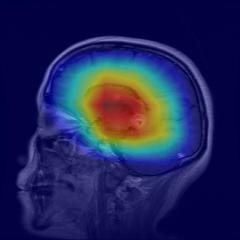

## Meningioma

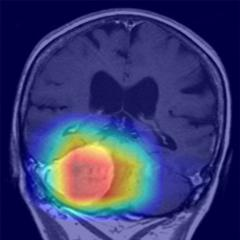

## Pituitary

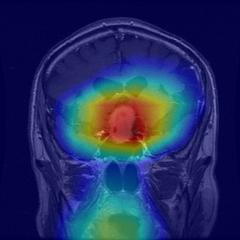